In [1]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callback.wandb import *
from PIL import Image, ImageOps
from fastai.vision.data import ImageDataLoaders

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,5)
plt.style.use('fivethirtyeight')
from fastai.vision.all import *
import timm
import warnings 
warnings.filterwarnings('ignore')

2023-04-01 20:11:15.459859: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 20:11:16.020990: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: teetouchoo. Use `wandb login --relogin` to force relogin


True

In [3]:
def random_seed(seed_value, use_cuda): 
    np.random.seed(seed_value)

    torch.manual_seed(seed_value) 

    random.seed(seed_value)

    if use_cuda: 
        torch.cuda.manual_seed(seed_value) 
        torch.cuda.manual_seed_all(seed_value) 

        backends.cudnn.deterministic = True 

        torch.backends.cudnn.benchmark = False 


random_seed(2023,True)

In [4]:
import albumentations
from albumentations.pytorch import ToTensorV2

In [30]:
class AlbumentationsTransform (RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    


<h1>Data Augmentation</h1>

In [6]:
# train_data = pd.read_csv('train_new.csv')
# train_data
train_data = pd.read_csv('pesudo_label.csv')
train_data

,image_path,label
0,data/test/test/0.jpg,28
1,data/test/test/1.jpg,8
2,data/test/test/2.jpg,9
3,data/test/test/3.jpg,26
4,data/test/test/4.jpg,35
...,...,...
76921,data/train/train/18/Set3_M1_P-0074_48.jpg,18
76922,data/train/train/18/Set4_F1_P-0191_52.jpg,18
76923,data/train/train/18/Set4_F1_P-0232_52.jpg,18
76924,data/train/train/18/Set4_F1_P-0083_58.jpg,18


In [7]:
import numpy as np

def auto_contrast(img):
    # Compute the histogram
     # Compute the histogram
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])
    threshold =240
    # Find the minimum and maximum intensity values
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    cdf_m = np.ma.masked_equal(cdf_normalized, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m, 0).astype('uint8')
    min_intensity = np.argmin(cdf)
    max_intensity = np.argmax(cdf)

    # Compute the scaling factor
    scale_factor = 255.0 / (max_intensity - min_intensity)

    # Apply auto contrast
    img = (img - min_intensity) * scale_factor
    img = np.clip(img, 0, 255)

    # Convert to binary image
    img[img < threshold] = 0
    img[img >= threshold] = 255

    # Return the output image
    return img.astype('uint8')

from albumentations import ImageOnlyTransform

class AutoContrast(ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1.0):
        super().__init__(always_apply=always_apply, p=p)

    def apply(self, img, **params):
        return auto_contrast(img)
        
    def get_transform_init_args_names(self):
        return ()

In [8]:
size = 224
def get_train_aug(): return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=size, width=size, interpolation=0),
            #albumentations.PadIfNeeded(always_apply=False, p=1.0, min_height=size, min_width=size, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            albumentations.Rotate(limit=(-25, 25)),
            #albumentations.HorizontalFlip(p=0.5),
            #albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(always_apply=False, p=1.0, shift_limit_x=(-0.06, 0.06), shift_limit_y=(-0.06, 0.06), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-25, 25), interpolation=0, border_mode=0, value=(255, 255, 255), mask_value=None, rotate_method='largest_box'),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.RandomGamma(),
            albumentations.ToGray(always_apply=False, p=1.0)
            #AutoContrast(),
           #albumentations.RandomGridShuffle(p=0.5)\
    ], p=1.)



def get_valid_aug(): return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=size, width=size, interpolation=0),
  
            #albumentations.PadIfNeeded(always_apply=False, p=1.0, min_height=size, min_width=size, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None),
            albumentations.ToGray(always_apply=False, p=1.0),
            #AutoContrast(),
             
            ], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

In [9]:
get_train_aug()

Compose([
  Resize(always_apply=False, p=1.0, height=224, width=224, interpolation=0),
  Rotate(always_apply=False, p=0.5, limit=(-25, 25), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False),
  ShiftScaleRotate(always_apply=False, p=1.0, shift_limit_x=(-0.06, 0.06), shift_limit_y=(-0.06, 0.06), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-25, 25), interpolation=0, border_mode=0, value=(255, 255, 255), mask_value=None, rotate_method='largest_box'),
  HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-0.2, 0.2), sat_shift_limit=(-0.2, 0.2), val_shift_limit=(-0.2, 0.2)),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True),
  RandomGamma(always_apply=False, p=0.5, gamma_limit=(80, 120), eps=None),
  ToGray(always_apply=False, p=1.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [10]:
blocks = (ImageBlock, CategoryBlock)
splitter = TrainTestSplitter(0.15, stratify=train_data["label"],random_state=42,shuffle=True)
block = DataBlock(blocks = blocks,
                 get_x=ColReader(0),
                 get_y=ColReader(1),
                 splitter = splitter,
                 item_tfms = item_tfms,
                 batch_tfms = batch_tfms)

dls = block.dataloaders(train_data, bs=16)

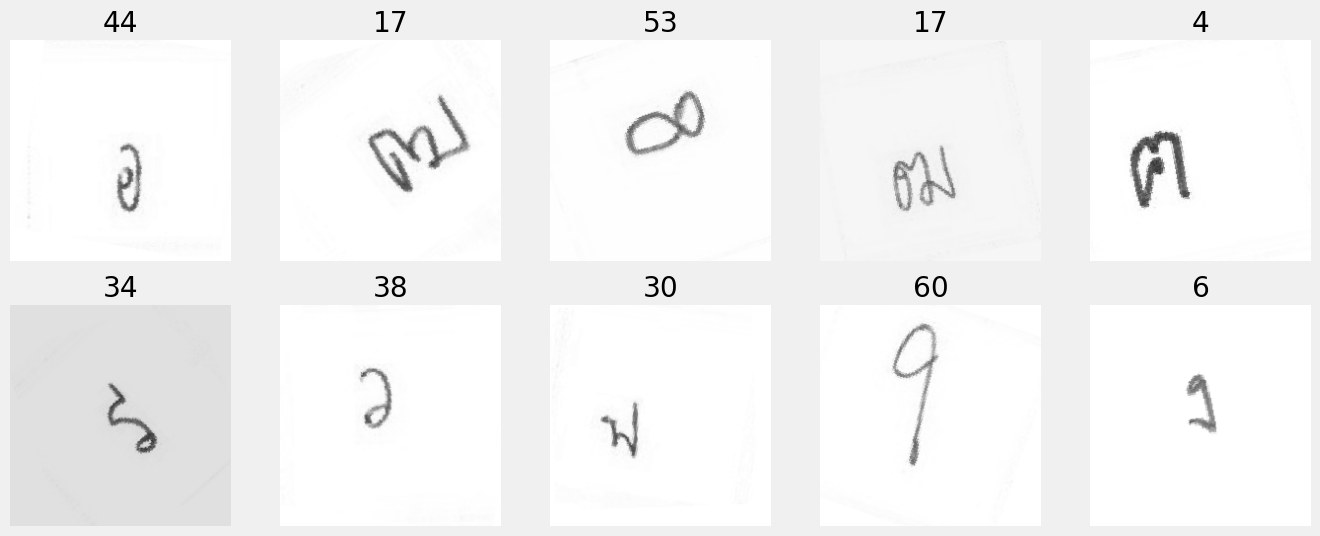

In [11]:
# to view
dls.show_batch(max_n=10,nrows=2)

<h1>Model</h1>

In [ ]:
import timm

timm.list_models('eva*')

In [13]:
from fastai.callback.wandb import *
learn = vision_learner(dls,'eva02_large_patch14_224', metrics=accuracy, path=".",cbs= [SaveModelCallback(monitor='valid_loss'),WandbCallback()])
learn.to_fp16()

In [14]:
from fastai.callback.wandb import *
#wandb.init(project='Eva')
wandb.init(project='Augmentation')

In [15]:
#learn.fit_one_cycle(5)
# learn.unfreeze()
#learn.fit_one_cycle(2)


In [16]:
#learn.fit_one_cycle(10, slice(1e-5,1e-4))
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.627039,0.295302,0.906838,17:10


Better model found at epoch 0 with valid_loss value: 0.2953015863895416.


epoch,train_loss,valid_loss,accuracy,time
0,0.362505,0.176700,0.949389,23:18
1,0.215828,0.142364,0.960049,23:18
2,0.165924,0.120043,0.967848,23:19
3,0.118929,0.102394,0.971315,23:19
4,0.086906,0.098478,0.974348,23:20


Better model found at epoch 0 with valid_loss value: 0.17670020461082458.
Better model found at epoch 1 with valid_loss value: 0.14236365258693695.
Better model found at epoch 2 with valid_loss value: 0.1200433075428009.
Better model found at epoch 4 with valid_loss value: 0.09847789257764816.


In [36]:
train_data

,image_path,label
0,data/train/train/2/Set3_F1_P-0071_17.jpg,2
1,data/train/train/2/Set3_F1_P-0130_17.jpg,2
2,data/train/train/2/Set4_F1_P-0200_24.jpg,2
3,data/train/train/2/Set4_F1_P-0061_25.jpg,2
4,data/train/train/2/Set4_F1_P-0170_29.jpg,2
...,...,...
63322,data/train/train/18/Set3_M1_P-0074_48.jpg,18
63323,data/train/train/18/Set4_F1_P-0191_52.jpg,18
63324,data/train/train/18/Set4_F1_P-0232_52.jpg,18
63325,data/train/train/18/Set4_F1_P-0083_58.jpg,18


In [17]:
learn.save("pesudo_eva2L224")

Path('models/pesudo_eva2L224.pth')

In [49]:
len(test_df)

63327

In [ ]:
# test_df = pd.read_csv("train_new.csv")

# # Create a DataBlock for the test data
# test_data = DataBlock(
#     blocks=(ImageBlock, CategoryBlock),
#     get_x=ColReader('image_path'),
#     get_y=ColReader('label'),
#     item_tfms = item_tfms,
#     batch_tfms = batch_tfms
# )

# test_dl = test_data.dataloaders(train_data, bs=64)

# # Get predictions for the test data
# test_preds = learn.get_preds(dl=test_dl)

# # Get the predicted labels
# test_preds_labels = test_preds[0].argmax(dim=1)

# # Get the file names
# test_file_names = test_data['image_path'].tolist()

# # Loop over the test data and print out the file names and predicted labels for the images that were predicted incorrectly
# for i in range(len(test_preds_labels)):
#     if test_preds_labels[i] != test_dl.dataset[i][1]:
#         print(f"Image file name: {test_file_names[i]}, Predicted label: {learn.dls.vocab[test_preds_labels[i]]}, Actual label: {learn.dls.vocab[test_dl.dataset[i][1]]}")
#         img = PIL.Image.open(test_file_names[i])
#         img.show()

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

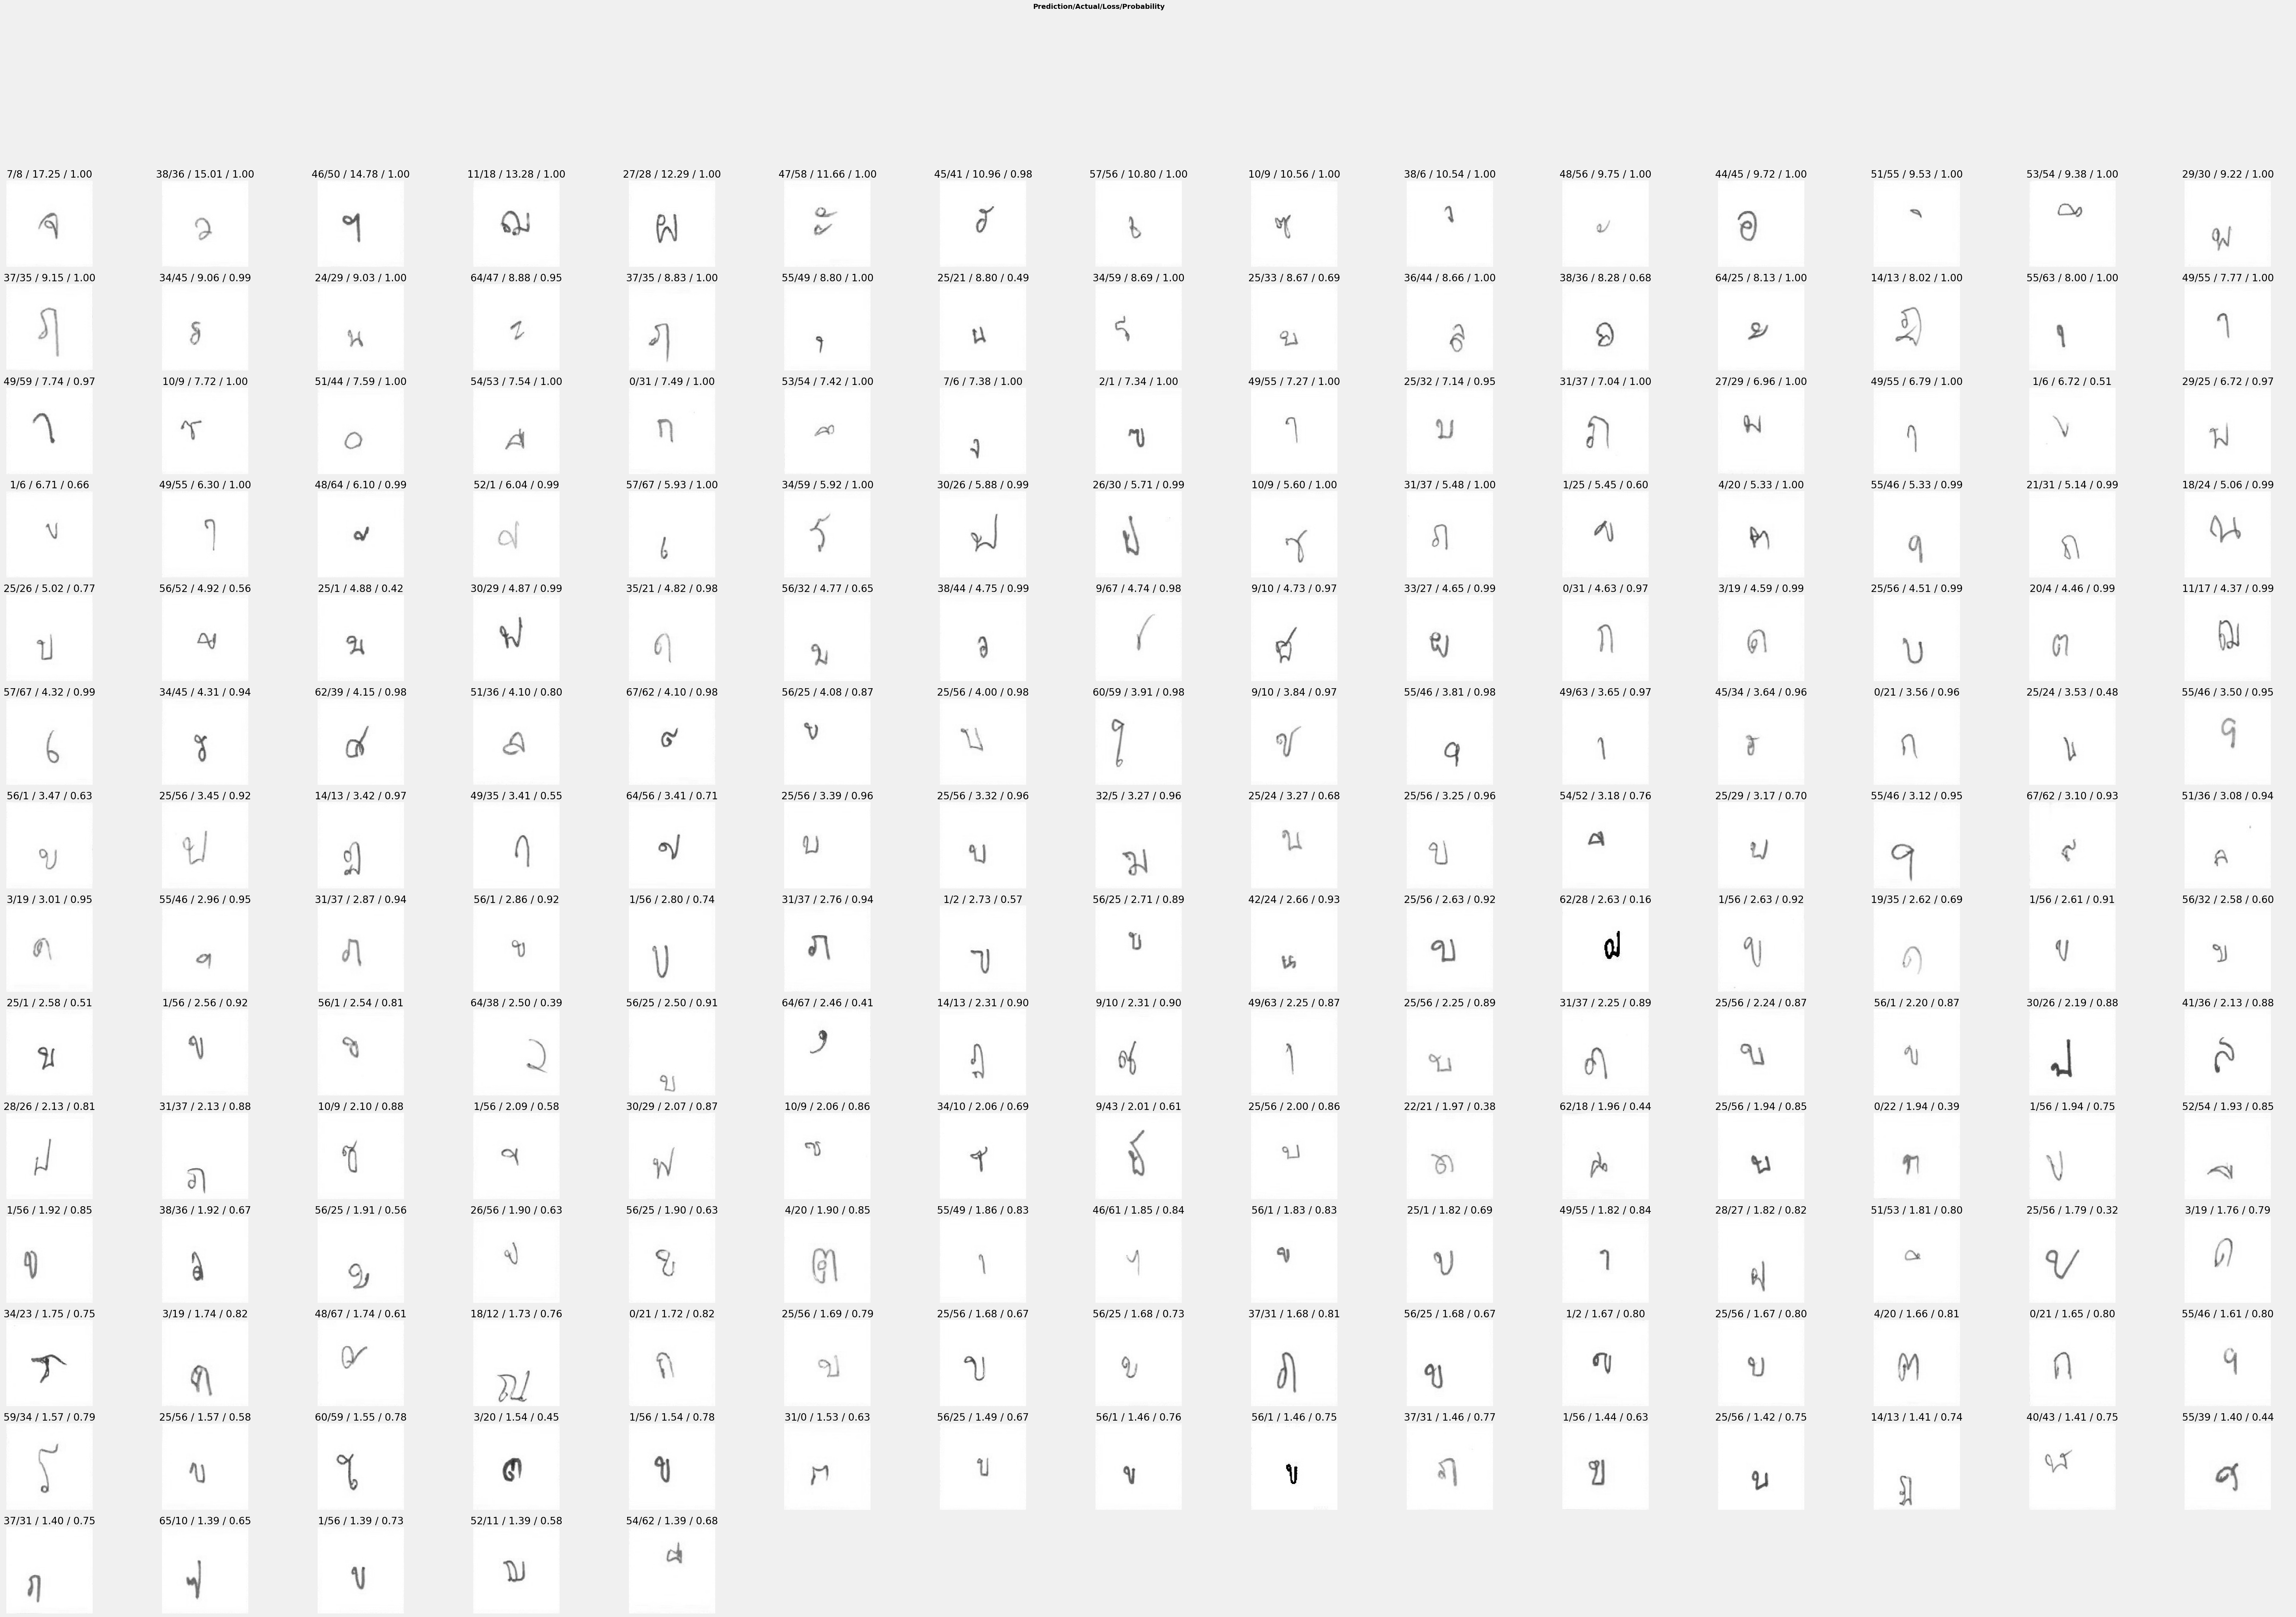

In [19]:
interp.plot_top_losses(200, figsize=(75,50))

In [ ]:
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(50,50))

<h1>eva</h1>

In [17]:
interp

<h1>Predict TTA</h1>

In [20]:
test = pd.read_csv('data/submission.csv')

In [21]:
test['filename'] = test['filename'].apply(lambda x:"data/test/test/" +x)

In [22]:
test

,filename,class
0,data/test/test/0.jpg,28.0
1,data/test/test/1.jpg,8.0
2,data/test/test/2.jpg,9.0
3,data/test/test/3.jpg,NaN
4,data/test/test/4.jpg,NaN
...,...,...
13594,data/test/test/13594.jpg,NaN
13595,data/test/test/13595.jpg,NaN
13596,data/test/test/13596.jpg,NaN
13597,data/test/test/13597.jpg,NaN


In [23]:
tst_dl = dls.test_dl(test.filename)

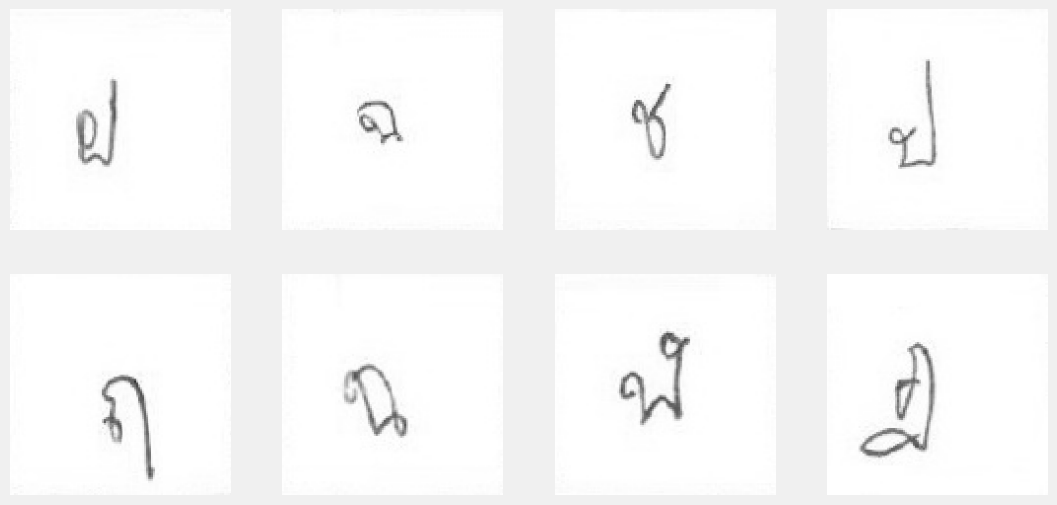

In [24]:
tst_dl.show_batch(max_n=8,nrows=2)

In [29]:
#tta = learn.tta(dl=tst_dl, n=40)
tta = learn.tta(dl=tst_dl, n=1)

In [31]:
tta

(tensor([[7.6957e-07, 2.8321e-07, 3.0033e-07,  ..., 1.9974e-06, 5.2278e-07,
          3.5748e-06],
         [1.3161e-08, 5.8259e-09, 3.0804e-09,  ..., 5.6675e-09, 4.5837e-08,
          2.5716e-08],
         [7.2414e-09, 2.0589e-06, 1.2267e-08,  ..., 2.8654e-09, 2.4994e-08,
          8.4275e-07],
         ...,
         [2.4059e-07, 3.8934e-07, 6.4393e-08,  ..., 3.7377e-08, 1.3026e-07,
          1.6317e-07],
         [6.9082e-06, 2.3889e-02, 6.2243e-05,  ..., 1.7939e-07, 2.6657e-07,
          2.6899e-06],
         [5.1324e-04, 7.1197e-06, 4.7216e-06,  ..., 7.9540e-07, 2.9219e-06,
          3.7685e-07]]),
 None)

In [32]:
tta_preds, _ = tta
idxs = tta_preds.argmax(dim=1)
vocab = np.array(dls.vocab)
sub = pd.read_csv('data/submission.csv')
sub['class'] = vocab[idxs]



In [33]:
sub.to_csv('40PESUDO_EVA2L_Gosubmission.csv', index=False)


In [30]:
!ls

2contrast_eva2large224_Gosubmission.csv
EDA.ipynb
Giant_Gosubmission.csv
Gosubmission.csv
TTA20_Gosubmission.csv
TTA_117_EVA2L_Gosubmission.csv
clean_data.ipynb
color_Gosubmission.csv
data
e-yes-efficient.ipynb
models
new_v2.ipynb
pytorch-image-models
rotate119_eva2base224_Gosubmission.csv
thai-handwritten-characters-recognition.zip
train.csv
train_new.csv
wandb


In [ ]:
sub

<h1>CHECK CSV FILE</h1>

In [ ]:
import pandas as pd
from PIL import Image

# read in the two CSV files as pandas dataframes
df1 = pd.read_csv('TTA_117_EVA2L_Gosubmission.csv')
df2 = pd.read_csv('NOTTA_117_EVA2L_Gosubmission.csv')

df1['filename'] = df1['filename'].apply(lambda x:"data/test/test/" +x)
df2['filename'] = df2['filename'].apply(lambda x:"data/test/test/" +x)
# merge the two dataframes on the filename column
merged_df = pd.merge(df1, df2, on='filename')
merged_df
# filter the merged dataframe to only show rows where the labels don't match
mismatched_labels = merged_df[merged_df['class_x'] != merged_df['class_y']]

# loop through the mismatched rows and display the image and labels
for index, row in mismatched_labels.iterrows():
    img = Image.open(row['filename'])
    img.show()
    print(f"Label in file1: {row['class_x']}, Label in file2: {row['class_y']}")